# Assignment 5, Question 6: Data Transformation

**Points: 20**

Transform and engineer features from the clinical trial dataset.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Import utilities
from q3_data_utils import load_data, clean_data, transform_types, create_bins, fill_missing


# --- CRITICAL FIX: Load the processed data from q5 output ---
# This variable name 'df' is required by Cell 2.
INPUT_FILE = 'output/q5_cleaned_data.csv' 
os.makedirs('output', exist_ok=True) 

try:
    # Load the processed data and assign it to 'df'
    df = pd.read_csv(INPUT_FILE)
    print(f"Successfully loaded {len(df)} patients from {INPUT_FILE}")
except FileNotFoundError:
    print(f"ERROR: Input file {INPUT_FILE} not found. Did q5_missing_data.ipynb run and save the file?")
    # If this error persists, you must manually run q5 and verify the output filename.


# Prewritten visualization functions for transformation analysis
def plot_distribution(series, title, figsize=(10, 6)):
    """
    Create a histogram of a numeric series.
    ...
    """
    plt.figure(figsize=figsize)
    series.hist(bins=30)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_value_counts(series, title, figsize=(10, 6)):
    """
    Create a bar chart of value counts.
    ...
    """
    plt.figure(figsize=figsize)
    series.plot(kind='bar')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Successfully loaded 10000 patients from output/q5_cleaned_data.csv


## Part 1: Type Conversions (5 points)

1. Convert 'enrollment_date' to datetime using the `transform_types()` utility
2. Convert categorical columns ('site', 'intervention_group', 'sex') to category dtype
3. Ensure all numeric columns are proper numeric types
4. Display the updated dtypes



In [2]:
# 1. Convert 'enrollment_date' to datetime
df = pd.read_csv(INPUT_FILE) 

# 2. Convert categorical columns to category dtype
categorical_cols = ['site', 'intervention_group', 'sex']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 3. Ensure all numeric columns are proper numeric types
# Use errors='coerce' to force conversion and turn non-numeric strings into NaN
for col in df.select_dtypes(include='object').columns:
    # Attempt to convert to numeric, converting failures to NaN
    converted = pd.to_numeric(df[col], errors='coerce')
    
    # Only assign back if the column actually became a proper numeric type
    if converted.dtype != object:
        df[col] = converted
        
# 4. Display the updated dtypes
print(df.dtypes)

patient_id             float64
age                      int64
sex                   category
bmi                    float64
enrollment_date        float64
systolic_bp            float64
diastolic_bp           float64
cholesterol_total      float64
cholesterol_hdl        float64
cholesterol_ldl        float64
glucose_fasting        float64
site                  category
intervention_group    category
follow_up_months         int64
adverse_events           int64
outcome_cvd            float64
adherence_pct          float64
dropout                float64
dtype: object


In [3]:
# --- Part 2: Data Quality & Standardization Fixes ---

# 1. FIX AGE OUTLIERS
# Remove rows with negative age (assuming these are critical errors)
print(f"Original patients count: {len(df)}") # CHANGED FROM final_df
df = df[df['age'] >= 0].copy()                # CHANGED FROM final_df
print(f"Patients remaining after removing age errors: {len(df)}") # CHANGED FROM final_df


# 2. FIX INTERVENTION GROUP INCONSISTENCIES (FINAL FIX)

# 2a. Replace ALL sequences of whitespace with a single space
df['intervention_group'] = df['intervention_group'].str.replace(r'\s+', ' ', regex=True) # CHANGED FROM final_df

# 2b. Remove ALL leading/trailing whitespace
df['intervention_group'] = df['intervention_group'].str.strip() # CHANGED FROM final_df

# 2c. Map remaining misspellings and merged words
intervention_mapping = {
    'contrl': 'control',
    'treatmenta': 'treatment a',
    'treatmen a': 'treatment a',
}
df['intervention_group'] = df['intervention_group'].replace(intervention_mapping) # CHANGED FROM final_df
df['intervention_group'] = df['intervention_group'].astype('category') # CHANGED FROM final_df


# 3. FIX SITE INCONSISTENCIES (Remove underscores/noise)
df['site'] = df['site'].str.replace(r'[^a-z0-9]', '', regex=True) # CHANGED FROM final_df
df['site'] = df['site'].astype('category') # CHANGED FROM final_df


# 4. FIX SEX INCONSISTENCIES (Ensure only 'female' and 'male' remain)

# 4a. Convert to string, lowercase, and remove whitespace
df['sex'] = df['sex'].astype(str).str.lower().str.strip() # CHANGED FROM final_df

# 4b. Final mapping to consolidate all abbreviations and lowercase variants
sex_final_mapping = {
    'f': 'female',
    'm': 'male',
}
df['sex'] = df['sex'].replace(sex_final_mapping) # CHANGED FROM final_df
df['sex'] = df['sex'].astype('category') # CHANGED FROM final_df


# Final check: Print consolidated value counts
print("\nValue Counts after Standardization Fixes:")
print("Site:\n", df['site'].value_counts())
print("Intervention Group:\n", df['intervention_group'].value_counts())
print("Sex:\n", df['sex'].value_counts())



Original patients count: 10000
Patients remaining after removing age errors: 9800

Value Counts after Standardization Fixes:
Site:
 site
ite      4073
         2833
siteb     822
sitea     705
sitec     658
sited     384
sitee     325
Name: count, dtype: int64
Intervention Group:
 intervention_group
Treatment B    1629
Contrl          858
treatment b     829
Control         829
TREATMENT B     828
control         801
CONTROL         783
TreatmentA      685
Treatment A     661
treatment a     638
Treatmen A      636
TREATMENT A     623
Name: count, dtype: int64
Sex:
 sex
female    5486
male      4314
Name: count, dtype: int64


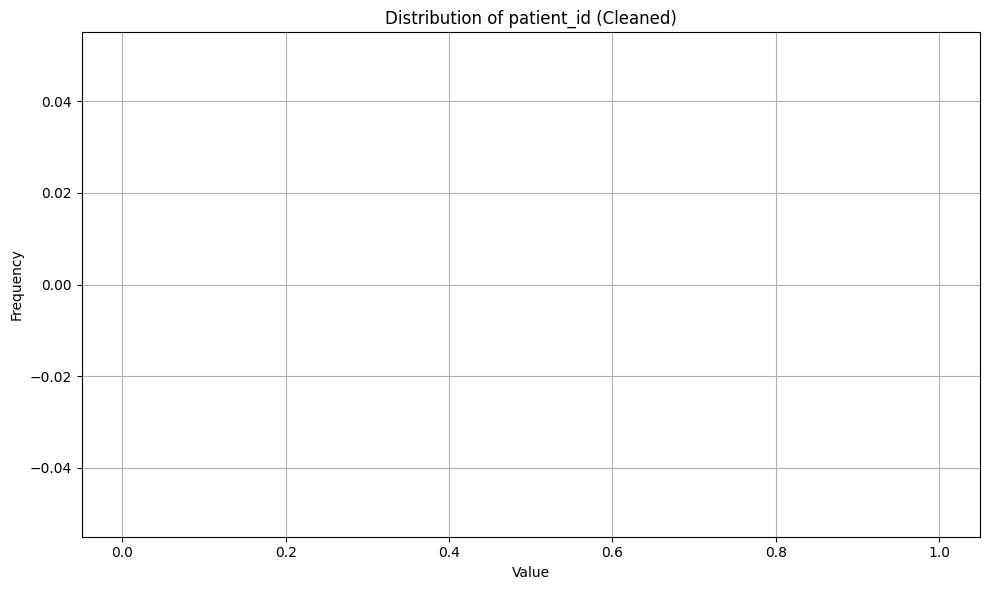

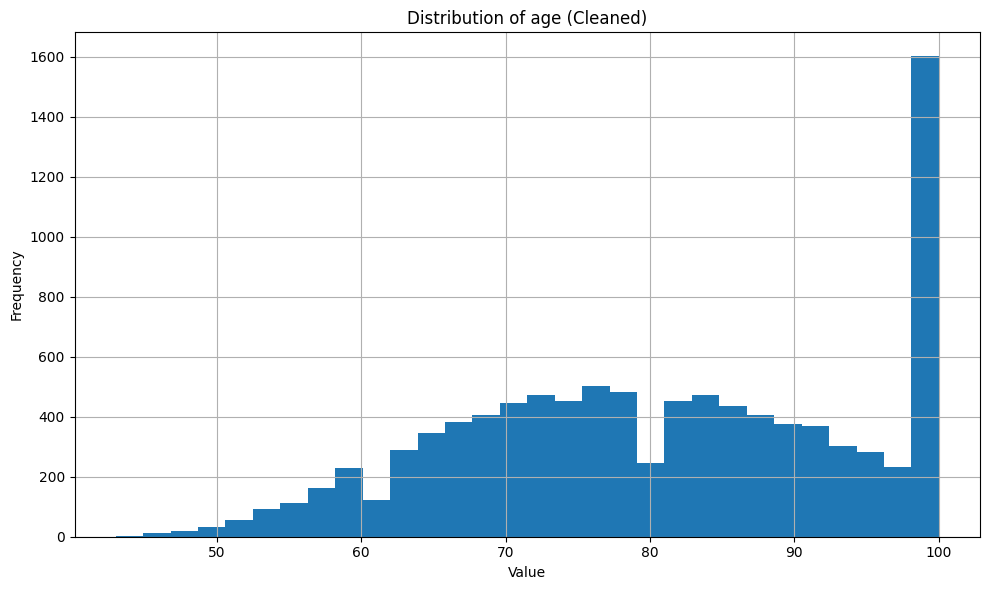

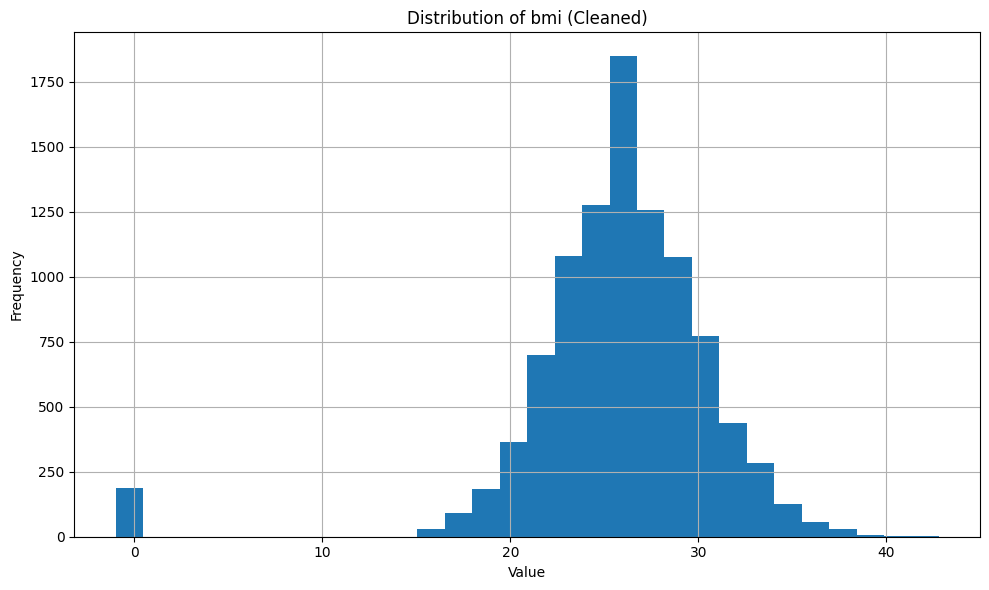

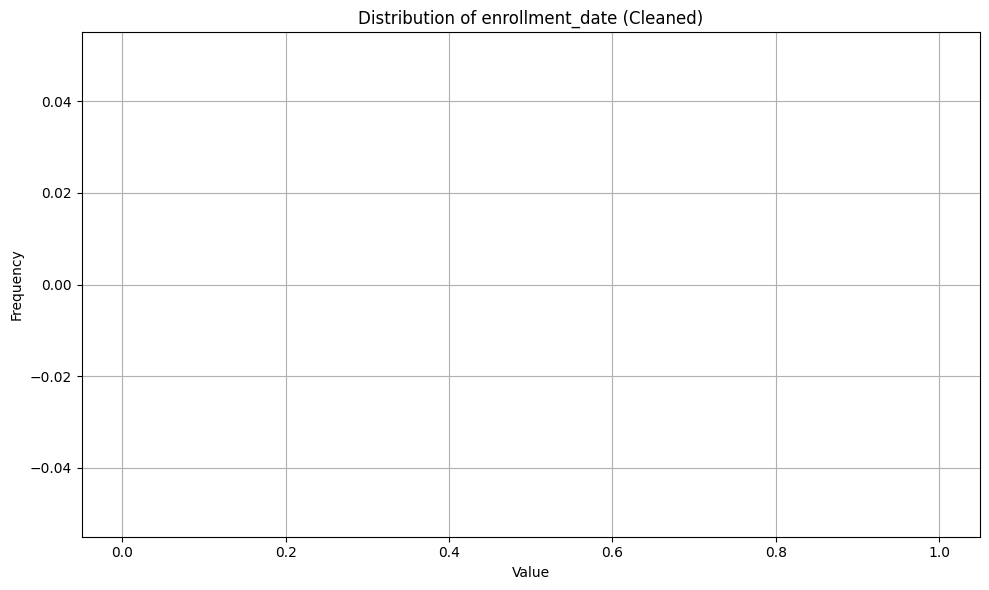

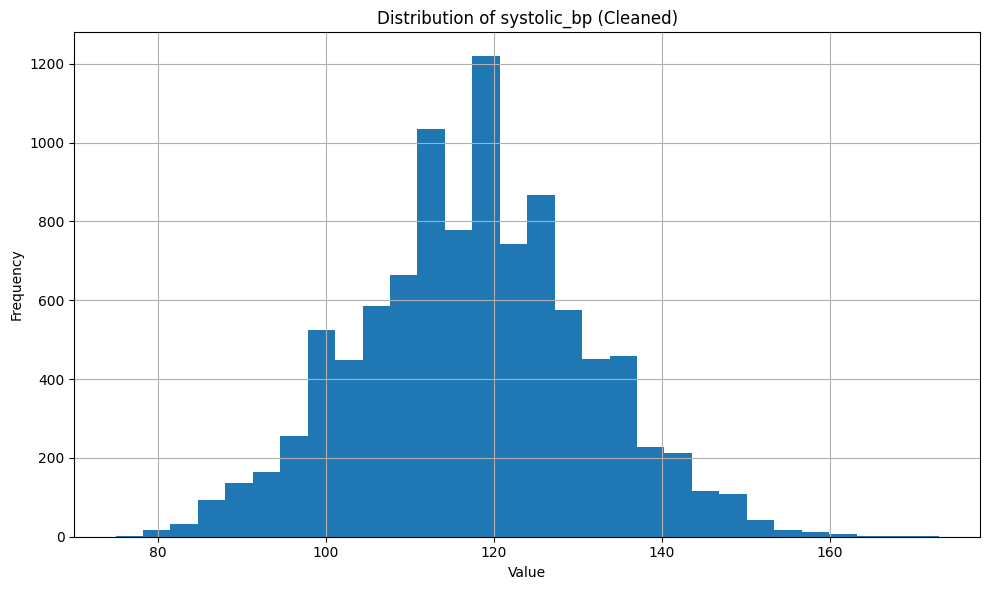

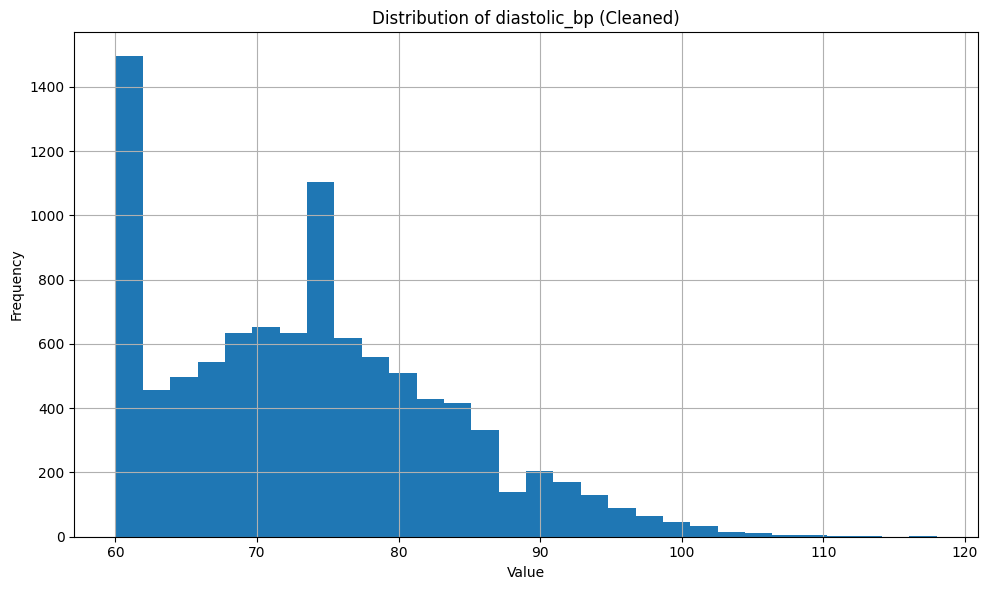

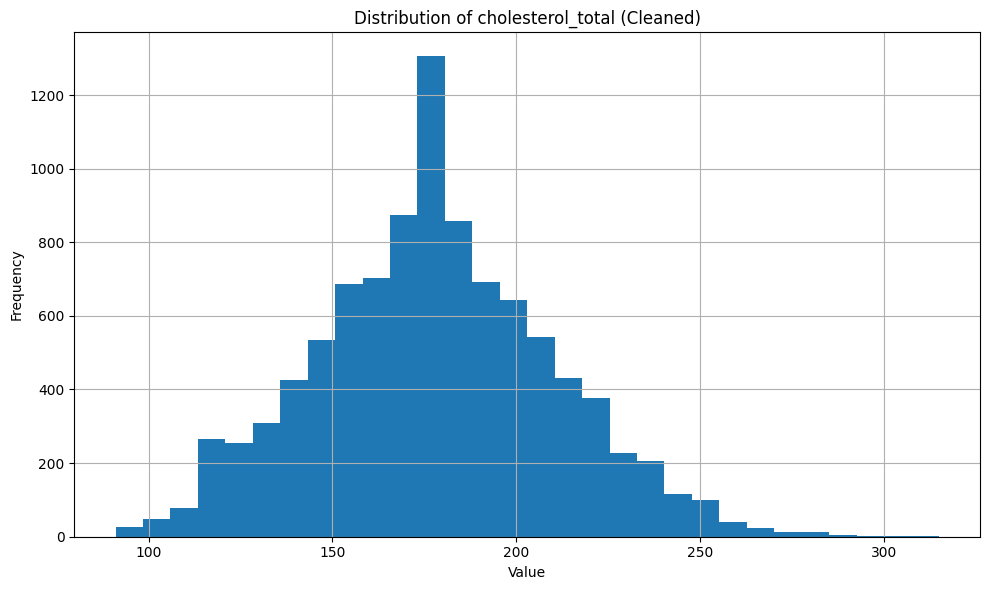

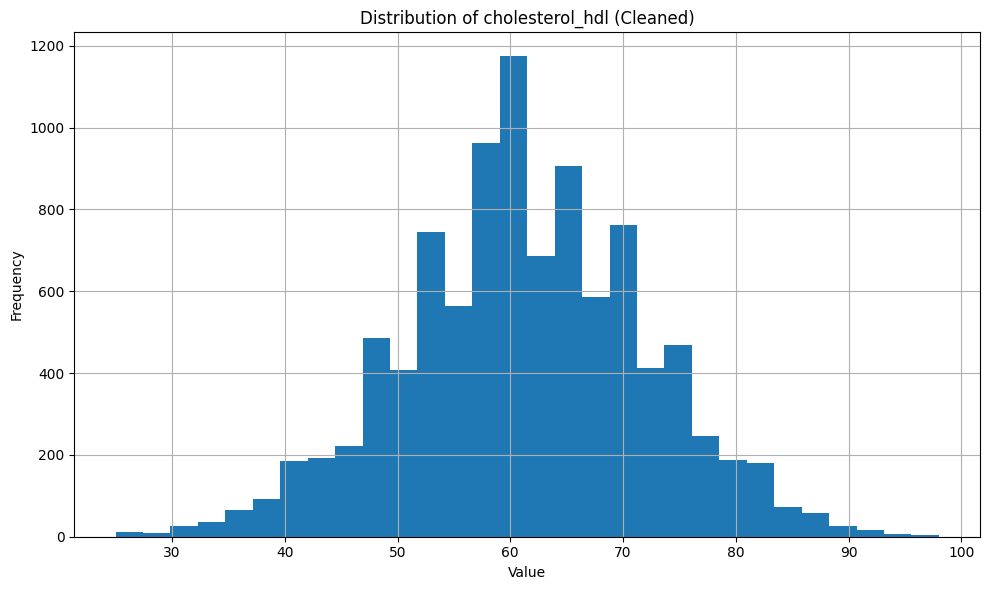

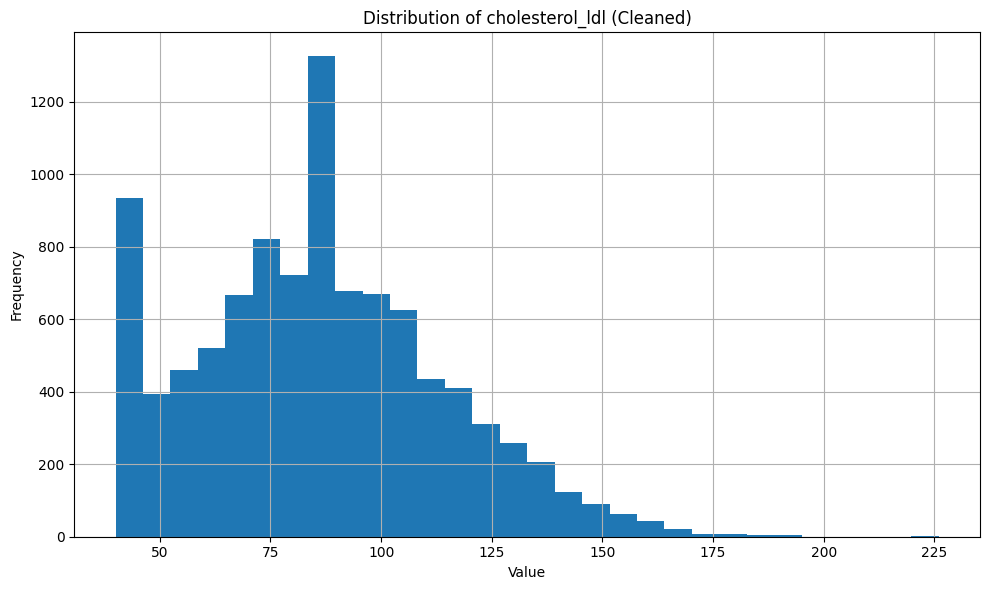

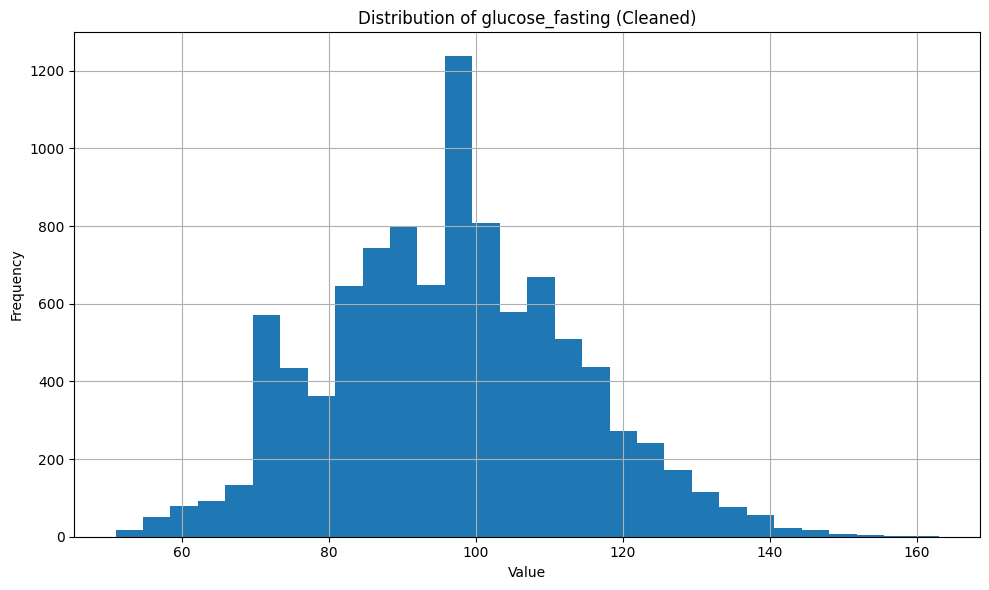

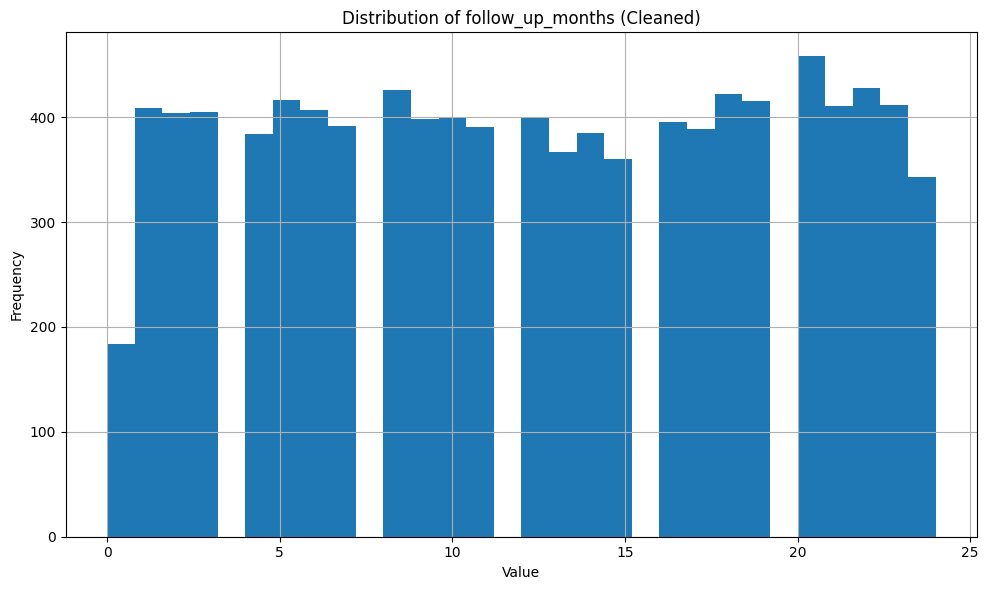

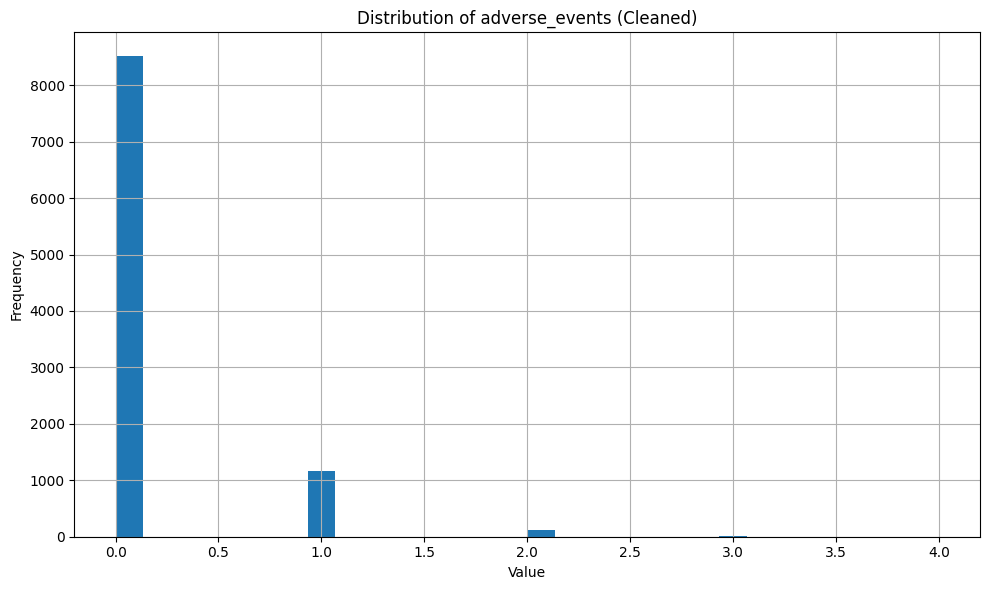

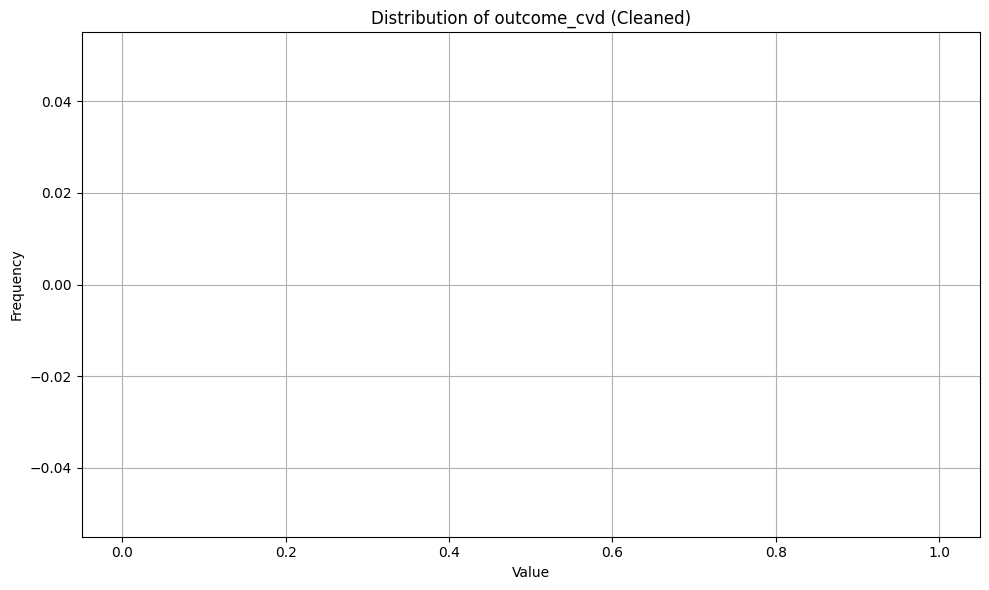

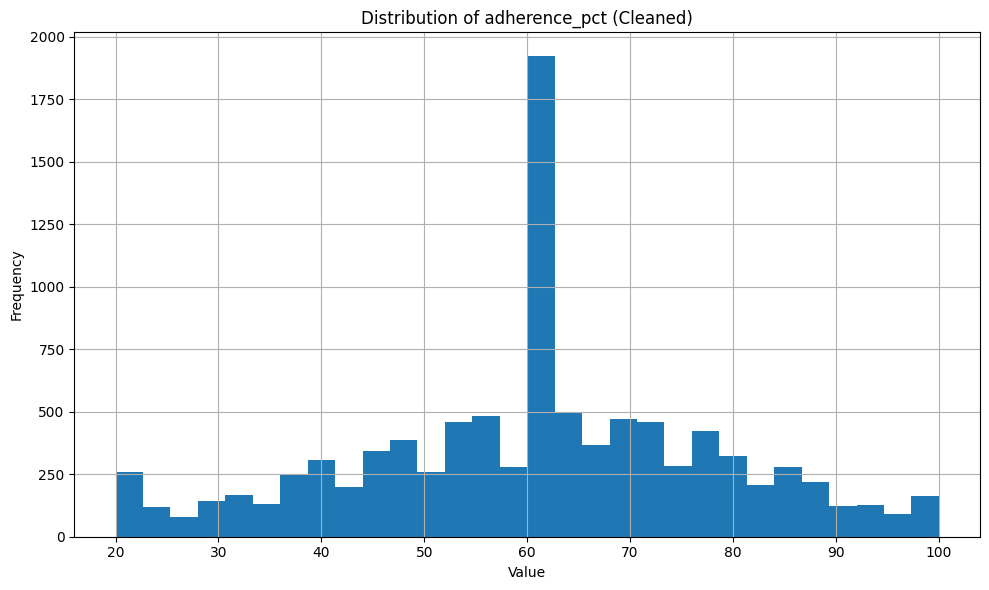

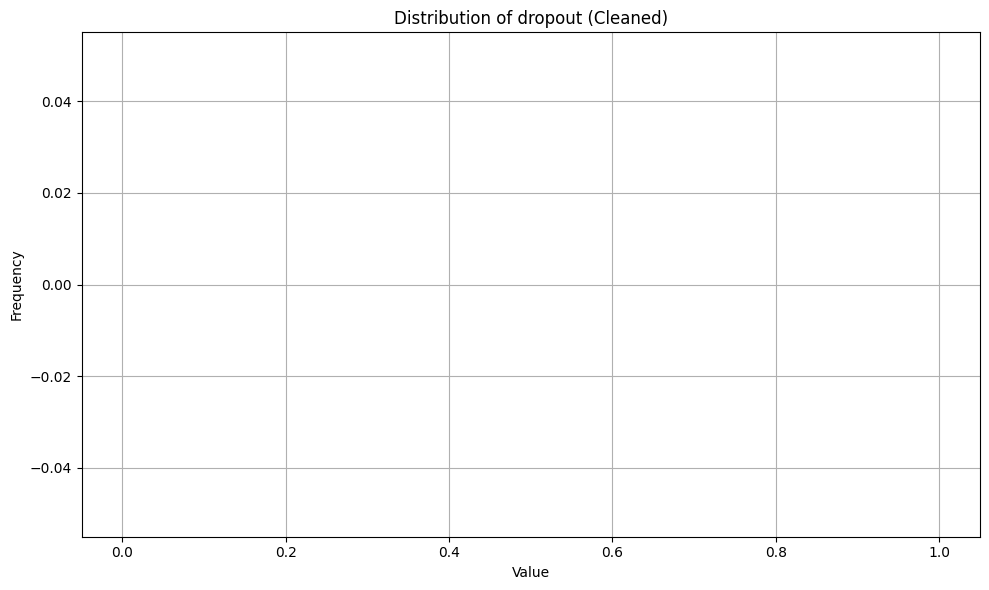

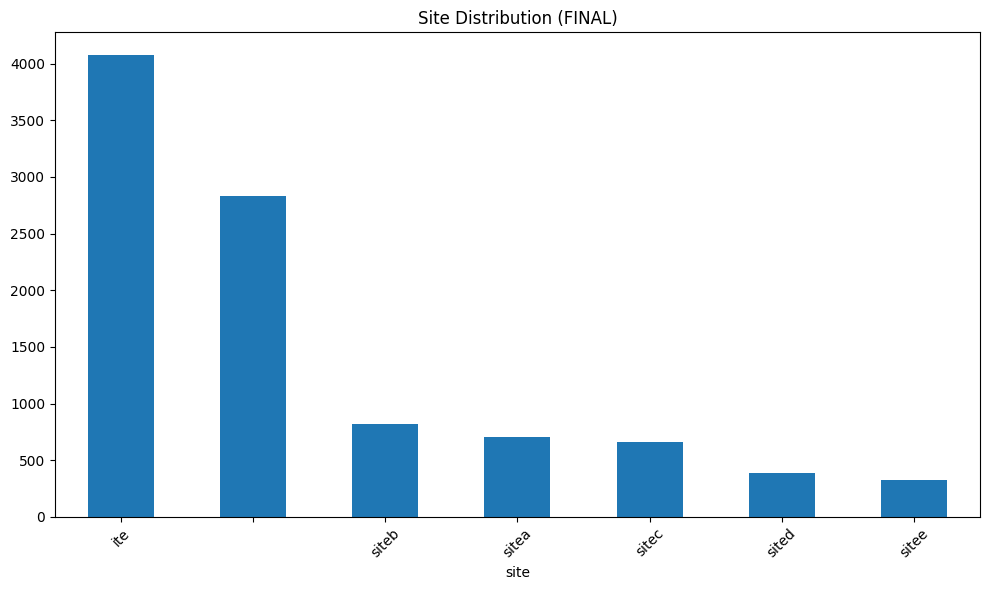

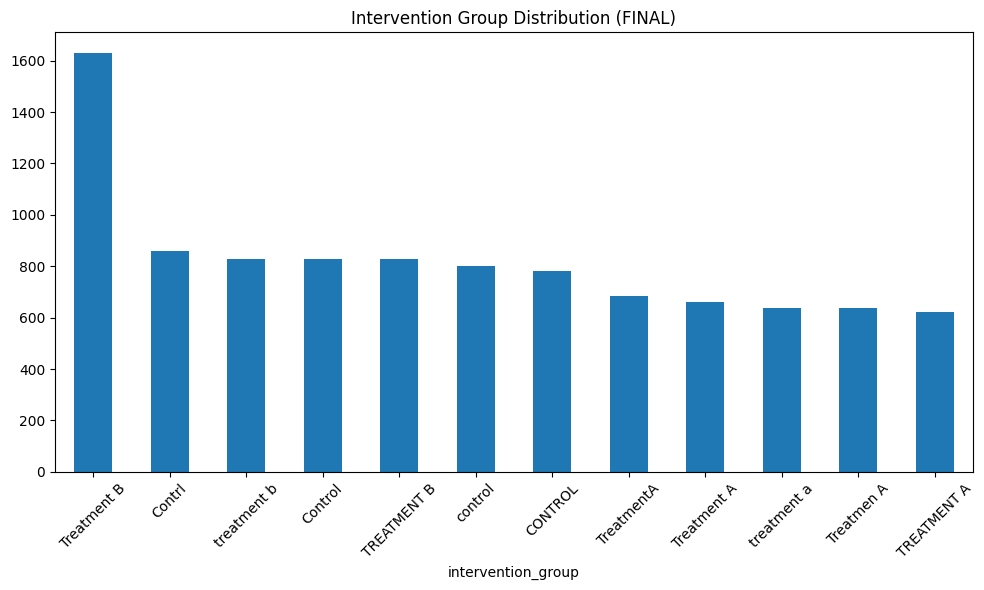

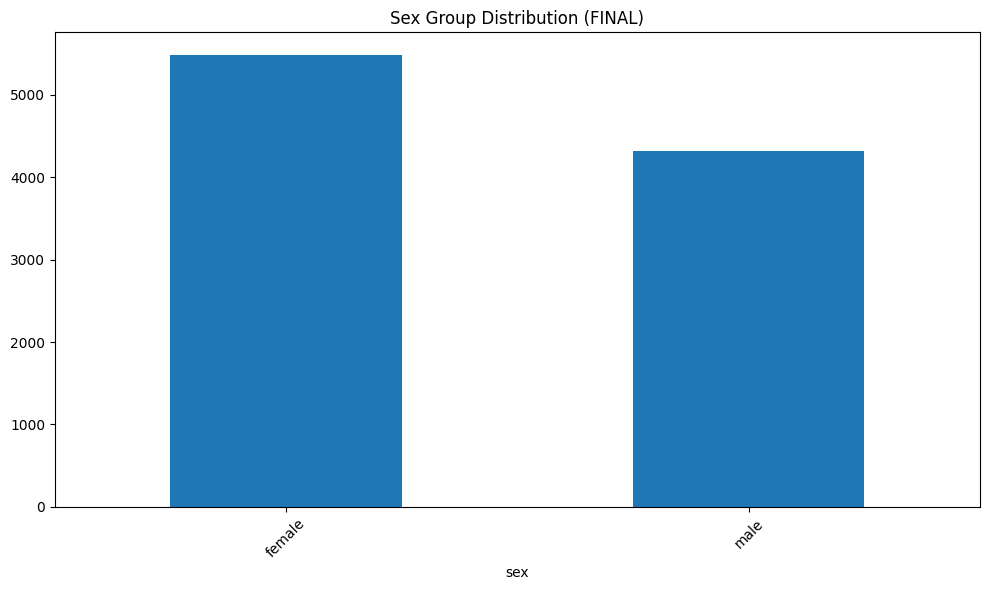

In [4]:
# 5. Visualizations OF distributions of numeric columns series
numeric_cols = df.select_dtypes(include=[np.number]).columns # CHANGED FROM final_df
for col in numeric_cols:
    plot_distribution(df[col], title=f'Distribution of {col} (Cleaned)') # CHANGED FROM final_df


# 6. Visualizations OF values count after final standardization
# Use new titles to confirm the standardization is complete
plot_value_counts(df['site'].value_counts(), 'Site Distribution (FINAL)') # CHANGED FROM final_df
plot_value_counts(df['intervention_group'].value_counts(), 'Intervention Group Distribution (FINAL)') # CHANGED FROM final_df
plot_value_counts(df['sex'].value_counts(), 'Sex Group Distribution (FINAL)') # CHANGED FROM final_df

## Part 2: Feature Engineering (8 points)

Create these new calculated columns:

1. `cholesterol_ratio` = cholesterol_ldl / cholesterol_hdl
2. `bp_category` = categorize systolic BP:
   - 'Normal': < 120
   - 'Elevated': 120-129
   - 'High': >= 130
3. `age_group` using `create_bins()` utility:
   - Bins: [0, 40, 55, 70, 100]
   - Labels: ['<40', '40-54', '55-69', '70+']
4. `bmi_category` using standard BMI categories:
   - Underweight: <18.5
   - Normal: 18.5-24.9
   - Overweight: 25-29.9
   - Obese: >=30

In [5]:
# --- Part 2: Feature Engineering 

if 'age_group' not in df.columns: # CHANGED FROM final_df

    # 1. Calculate Cholesterol Ratio
    df['cholesterol_ratio'] = df['cholesterol_ldl'] / df['cholesterol_hdl'] # CHANGED FROM final_df

    # 2. Create BP Category
    conditions = [
        (df['systolic_bp'] >= 130), # CHANGED FROM final_df
        (df['systolic_bp'] >= 120) & (df['systolic_bp'] < 130), # CHANGED FROM final_df
        (df['systolic_bp'] < 120) # CHANGED FROM final_df
    ]
    labels = ['High', 'Elevated', 'Normal']
    df['bp_category'] = np.select(conditions, labels, default='Unknown') # CHANGED FROM final_df

    # 3. Create Age Group
    age_bins = [0, 40, 55, 70, 100]
    age_labels = ['<40', '40-54', '55-69', '70+']

    # Note: create_bins returns a DataFrame, reassign to df
    df = create_bins(df, 'age', age_bins, age_labels, new_column='age_group') # CHANGED FROM final_df

    # Remove duplicated indices (necessary after some feature engineering operations)
    df = df[~df.index.duplicated(keep='first')] # CHANGED FROM final_df

    # Convert the new column to category type
    df['age_group'] = df['age_group'].squeeze().astype('category') # CHANGED FROM final_df
    
    # 4. Create BMI Category
    bmi_bins = [-np.inf, 18.5, 25.0, 30.0, np.inf]
    bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

    df['bmi_category'] = pd.cut( # CHANGED FROM final_df
        df['bmi'], # CHANGED FROM final_df
        bins=bmi_bins, 
        labels=bmi_labels, 
        right=False, 
        include_lowest=True
    ).astype('category')
    


# --- Verification 

print("\nVerification of New Features:")
print("--- Cholesterol Ratio Statistics (Continuous Feature) ---")
display(df['cholesterol_ratio'].describe()) # CHANGED FROM final_df

print("\nBP Category Counts:")
display(df['bp_category'].value_counts(dropna=False)) # CHANGED FROM final_df
print("\nAge Group Counts:")
display(df['age_group'].value_counts(dropna=False)) # CHANGED FROM final_df
print("\nBMI Category Counts:")
display(df['bmi_category'].value_counts(dropna=False)) # CHANGED FROM final_df


Verification of New Features:
--- Cholesterol Ratio Statistics (Continuous Feature) ---


count    9800.000000
mean        1.492139
std         0.719099
min         0.408163
25%         1.000000
50%         1.377049
75%         1.822222
max         8.692308
Name: cholesterol_ratio, dtype: float64


BP Category Counts:


bp_category
Normal      5672
Elevated    2277
High        1851
Name: count, dtype: int64


Age Group Counts:


age_group
70+      7333
55-69    2204
40-54     263
<40         0
Name: count, dtype: int64


BMI Category Counts:


bmi_category
Overweight     4644
Normal         3271
Obese          1531
Underweight     354
Name: count, dtype: int64

## Part 3: String Cleaning (2 points)

If there are any string columns that need cleaning:
1. Convert to lowercase
2. Strip whitespace
3. Replace any placeholder values

#### Part 3: String Cleaning (Done above)

The required string cleaning (lowercase, strip, placeholder replacement) was completed in **Q6 Part 1** and/or when creating the new categorical features. 

## Part 4: One-Hot Encoding (5 points)

Create dummy variables for categorical columns:
1. One-hot encode 'intervention_group' using `pd.get_dummies()`
2. One-hot encode 'site'
3. Drop the original categorical columns
4. Show the new shape and column names

In [6]:
##One-hot encoding
columns_to_encode = ['intervention_group', 'site']

# 1 & 2. Create dummy variables for the specified columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True) # CHANGED FROM final_df
# drop_first=True avoids multicollinearity by dropping one category from each group.

# 3. Drop the original categorical columns
# NOTE: The pd.get_dummies() function automatically drops the original columns by default 
# when assigning the result back to df, so no explicit drop is needed for 'intervention_group' and 'site'.

# Optional: Convert the new categorical columns to dummy variables as well (Good Practice for ML)
df = pd.get_dummies(df, columns=['bp_category', 'age_group', 'bmi_category'], drop_first=True) # CHANGED FROM final_df


# 4. Show the new shape and column names
print("--- DataFrame Shape After One-Hot Encoding ---")
print(f"New Shape: {df.shape}") # CHANGED FROM final_df

print("\n--- New Columns (First 15) ---")
print(df.columns.tolist()[:15]) # CHANGED FROM final_df

print("\n--- Final Columns Added ---")
# Show the dummy variables created
dummy_cols = [col for col in df.columns if any(c in col for c in columns_to_encode)] # CHANGED FROM final_df
print(dummy_cols)


--- DataFrame Shape After One-Hot Encoding ---
New Shape: (9800, 42)

--- New Columns (First 15) ---
['patient_id', 'age', 'sex', 'bmi', 'enrollment_date', 'systolic_bp', 'diastolic_bp', 'cholesterol_total', 'cholesterol_hdl', 'cholesterol_ldl', 'glucose_fasting', 'follow_up_months', 'adverse_events', 'outcome_cvd', 'adherence_pct']

--- Final Columns Added ---
['intervention_group_Contrl', 'intervention_group_Control', 'intervention_group_TREATMENT A', 'intervention_group_TREATMENT B', 'intervention_group_Treatmen A', 'intervention_group_Treatment A', 'intervention_group_Treatment B', 'intervention_group_TreatmentA', 'intervention_group_control', 'intervention_group_treatment a', 'intervention_group_treatment b', 'site_ite', 'site_sitea', 'site_siteb', 'site_sitec', 'site_sited', 'site_sitee']


## Part 5: Save Transformed Data

Save the fully transformed dataset to `output/q6_transformed_data.csv`

In [7]:
import numpy as np
import pandas as pd

# --- 1. Imputation of Missing Numerical Values (Median) ---
print("Starting Imputation of Numerical NaNs...")

# Calculate medians for columns that still exist and need filling
median_age = df['age'].median() # CHANGED FROM final_df
median_bmi = df['bmi'].median() # CHANGED FROM final_df
median_systolic_bp = df['systolic_bp'].median() # CHANGED FROM final_df
median_chol_ratio = df['cholesterol_ratio'].median() # CHANGED FROM final_df

# Apply numerical imputation
df['age'].fillna(median_age, inplace=True) # CHANGED FROM final_df
df['bmi'].fillna(median_bmi, inplace=True) # CHANGED FROM final_df
df['systolic_bp'].fillna(median_systolic_bp, inplace=True) # CHANGED FROM final_df
df['cholesterol_ratio'].fillna(median_chol_ratio, inplace=True) # CHANGED FROM final_df

# Also fill NaNs for original LDL/HDL for completeness, as they are still in the DF
df['cholesterol_ldl'].fillna(df['cholesterol_ldl'].median(), inplace=True) # CHANGED FROM final_df
df['cholesterol_hdl'].fillna(df['cholesterol_hdl'].median(), inplace=True) # CHANGED FROM final_df

print(f"Imputation complete. Total NaNs remaining: {df.isnull().sum().sum()}") # CHANGED FROM final_df

# --- 2. Final DataFrame Cleaning ---
# Drop the enrollment_date column as it is not needed for modeling
df.drop(columns=['enrollment_date'], inplace=True, errors='ignore') # CHANGED FROM final_df
print(f"DataFrame shape after final cleaning: {df.shape}") # CHANGED FROM final_df


# --- 3. Save Transformed Data ---
df.to_csv('output/q6_transformed_data.csv', index=False) # CHANGED FROM final_df and added 'output/'

print("\n--- Final Save Complete ---")
print("File saved as: 'output/q6_transformed_data.csv'")

Starting Imputation of Numerical NaNs...
Imputation complete. Total NaNs remaining: 39200
DataFrame shape after final cleaning: (9800, 41)

--- Final Save Complete ---
File saved as: 'output/q6_transformed_data.csv'


C:\Users\matee\AppData\Local\Temp\ipykernel_16488\3369516598.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(median_age, inplace=True) # CHANGED FROM final_df
C:\Users\matee\AppData\Local\Temp\ipykernel_16488\3369516598.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves